##### Import Packages

In [15]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('fivethirtyeight')

rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 1
warnings.filterwarnings("ignore")

import pandas_datareader.data as web
import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

##### Get the data

In [2]:
start_date = datetime.datetime.now() - datetime.timedelta(days=365*10) # 20 years ago
end_date = datetime.datetime.now()

wti = web.DataReader('DCOILWTICO', 'fred', start_date, end_date)
wti=wti.resample('W').mean()
wti=wti.rename({'DCOILWTICO':'WTI'}, axis=1)

ts=wti['WTI']
ts.head()

DATE
2013-03-10    91.0040
2013-03-17    92.7000
2013-03-24    93.0460
2013-03-31    96.0775
2013-04-07    95.0740
Freq: W-SUN, Name: WTI, dtype: float64

##### EDA

In [3]:
ts.describe()

count    522.000000
mean      65.498137
std       22.452274
min        3.324000
25%       48.503750
50%       59.803000
75%       82.074000
max      120.430000
Name: WTI, dtype: float64

In [4]:
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30, figsize=(15,5)):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)
    plt.title(ts.name)
    plt.plot(ts[window:], label='ts', color="black")
    if plot_ma:
        plt.plot(rolling_mean, 'g', label='MA'+str(window), color="red")
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
        plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound, color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

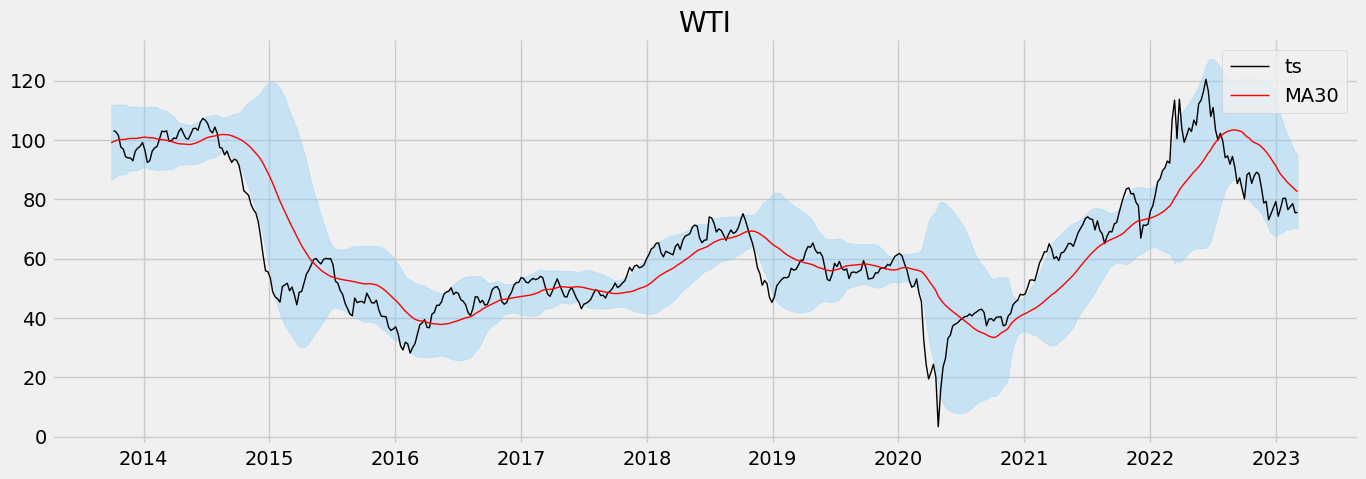

In [5]:
plot_ts(ts)

##### Test stationarity

In [9]:
def test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30, figsize=(15,10)):
        ## set figure
        fig = plt.figure(figsize=figsize)
        ts_ax = plt.subplot2grid(shape=(2,2), loc=(0,0), colspan=2)
        pacf_ax = plt.subplot2grid(shape=(2,2), loc=(1,0))
        acf_ax = plt.subplot2grid(shape=(2,2), loc=(1,1))
        
        ## plot ts with mean/std of a sample from the first x% 
        dtf_ts = ts.to_frame(name="ts")
        sample_size = int(len(ts)*sample)
        dtf_ts["mean"] = dtf_ts["ts"].head(sample_size).mean()
        dtf_ts["lower"] = dtf_ts["ts"].head(sample_size).mean() + dtf_ts["ts"].head(sample_size).std()
        dtf_ts["upper"] = dtf_ts["ts"].head(sample_size).mean() - dtf_ts["ts"].head(sample_size).std()
        dtf_ts["ts"].plot(ax=ts_ax, color="black", legend=False)
        dtf_ts["mean"].plot(ax=ts_ax, legend=False, color="red", linestyle="--", linewidth=0.7)
        ts_ax.fill_between(x=dtf_ts.index, y1=dtf_ts['lower'], y2=dtf_ts['upper'], color='lightskyblue', alpha=0.4)
        dtf_ts["mean"].head(sample_size).plot(ax=ts_ax, legend=False, color="red", linewidth=0.9)
        ts_ax.fill_between(x=dtf_ts.head(sample_size).index, y1=dtf_ts['lower'].head(sample_size), y2=dtf_ts['upper'].head(sample_size), color='lightskyblue')
        ts_ax.set(xlabel=None)

        ## test stationarity (Augmented Dickey-Fuller)
        adfuller_test = sm.tsa.stattools.adfuller(ts, maxlag=maxlag, autolag="AIC")
        adf, p, critical_value = adfuller_test[0], adfuller_test[1], adfuller_test[4]["5%"]
        p = round(p, 3)
        conclusion = "Stationary" if p < 0.05 else "Non-Stationary"
        ts_ax.set_title('Dickey-Fuller Test 95%: '+conclusion+' (p-value: '+str(p)+')')
        
        ## pacf (for AR) e acf (for MA) 
        plot_pacf(ts, lags=maxlag, ax=pacf_ax, title="Partial Autocorrelation (for AR component)")
        plot_acf(ts, lags=maxlag, ax=acf_ax, title="Autocorrelation (for MA component)")
        plt.tight_layout()

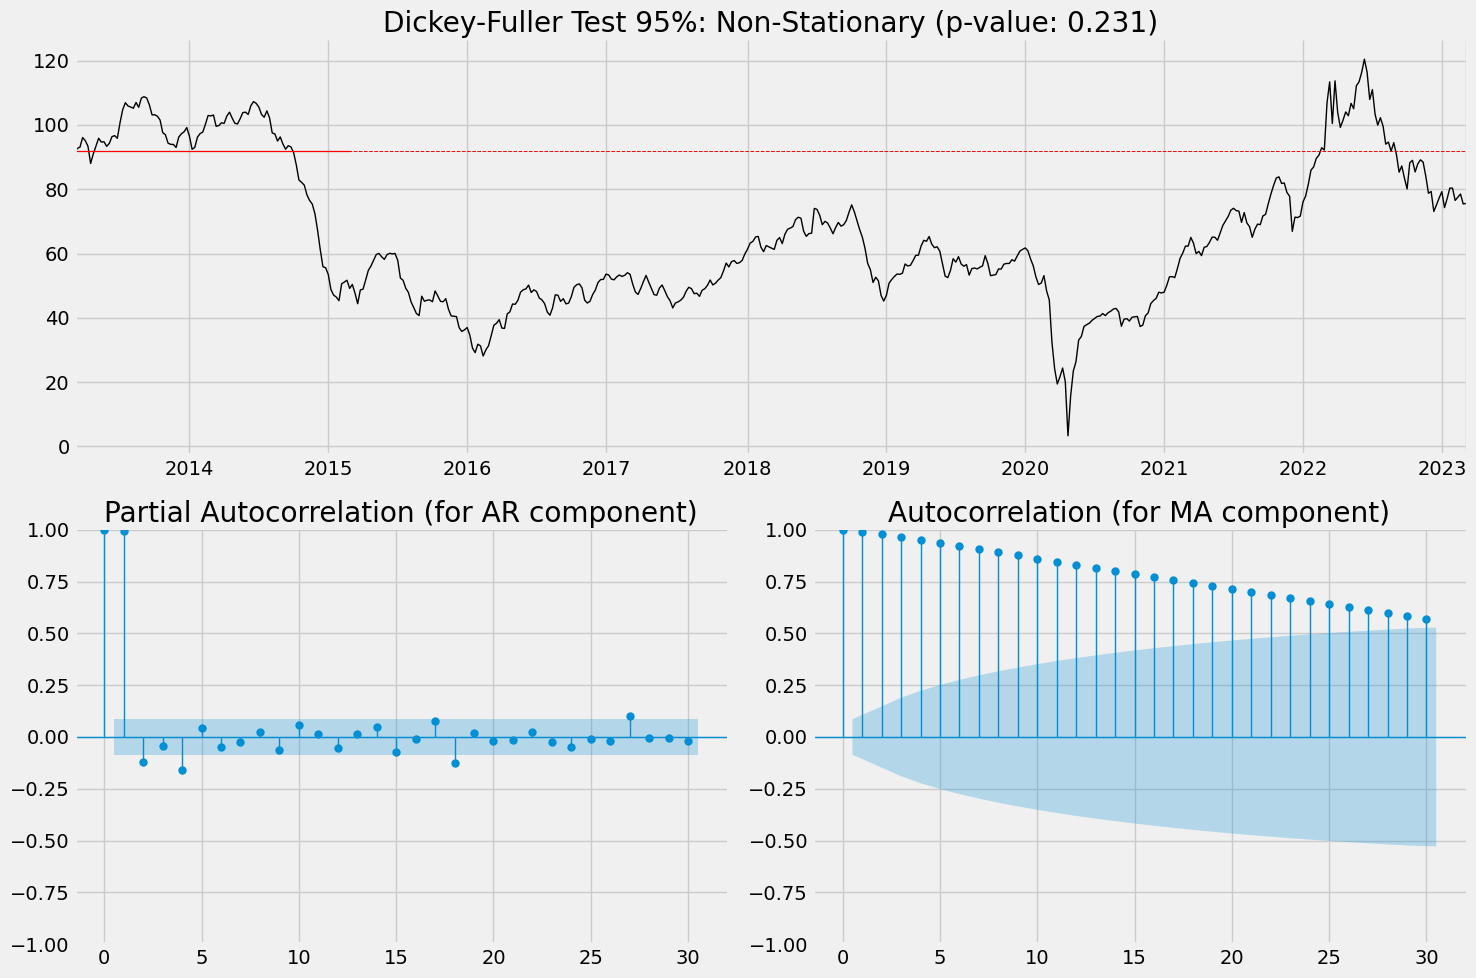

In [10]:
test_stationarity_acf_pacf(ts)

In [11]:
ts_diff=(ts-ts.shift(1)).dropna()

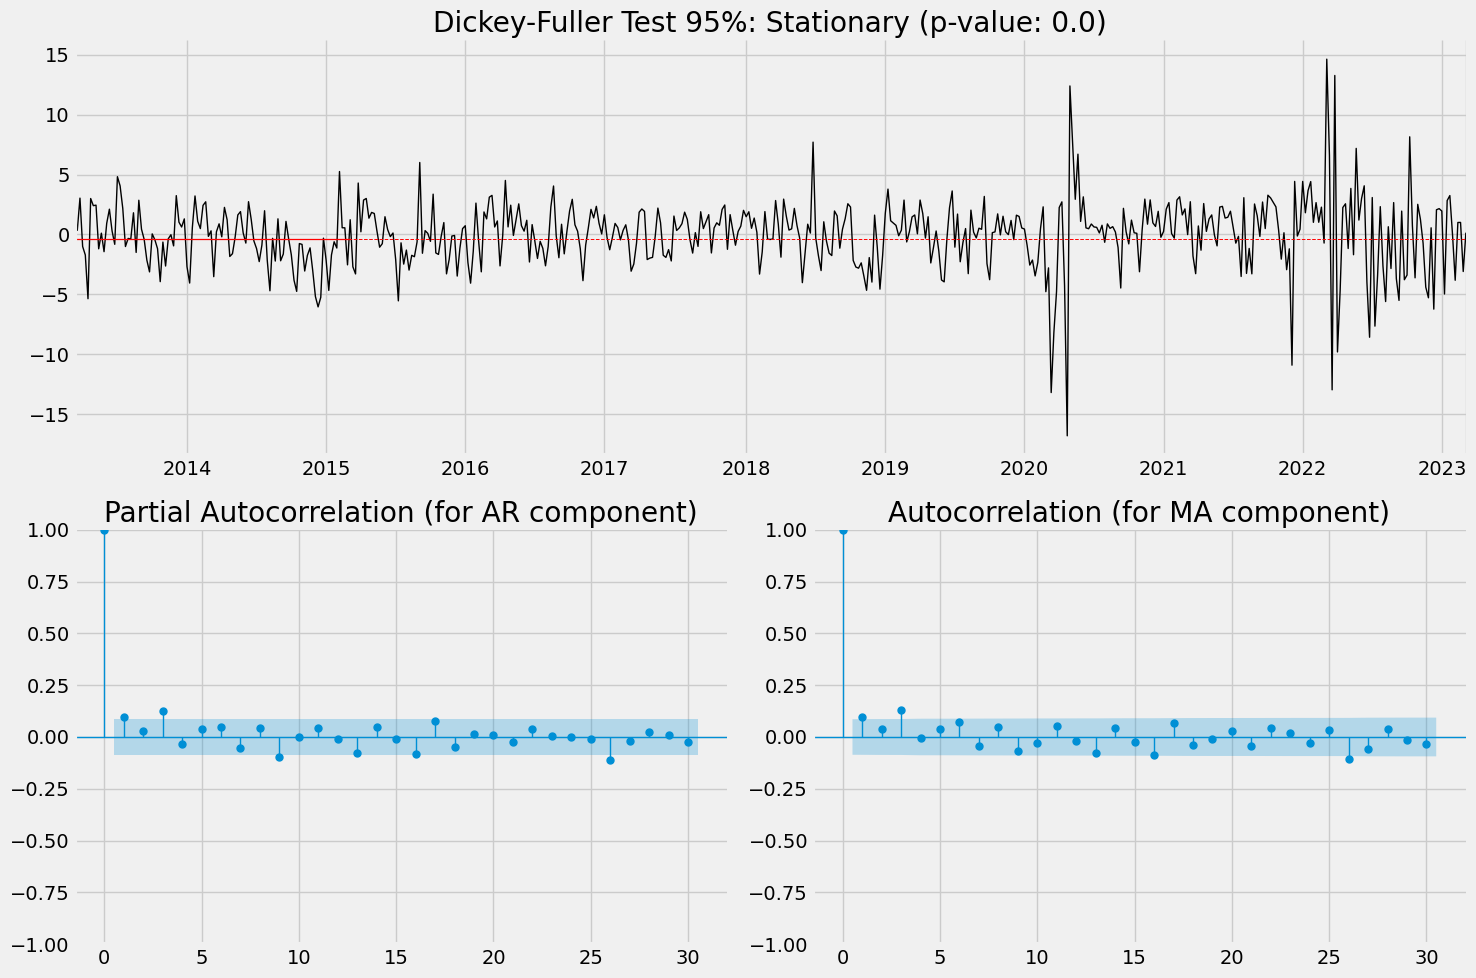

In [12]:
test_stationarity_acf_pacf(ts_diff)

##### Seasonality

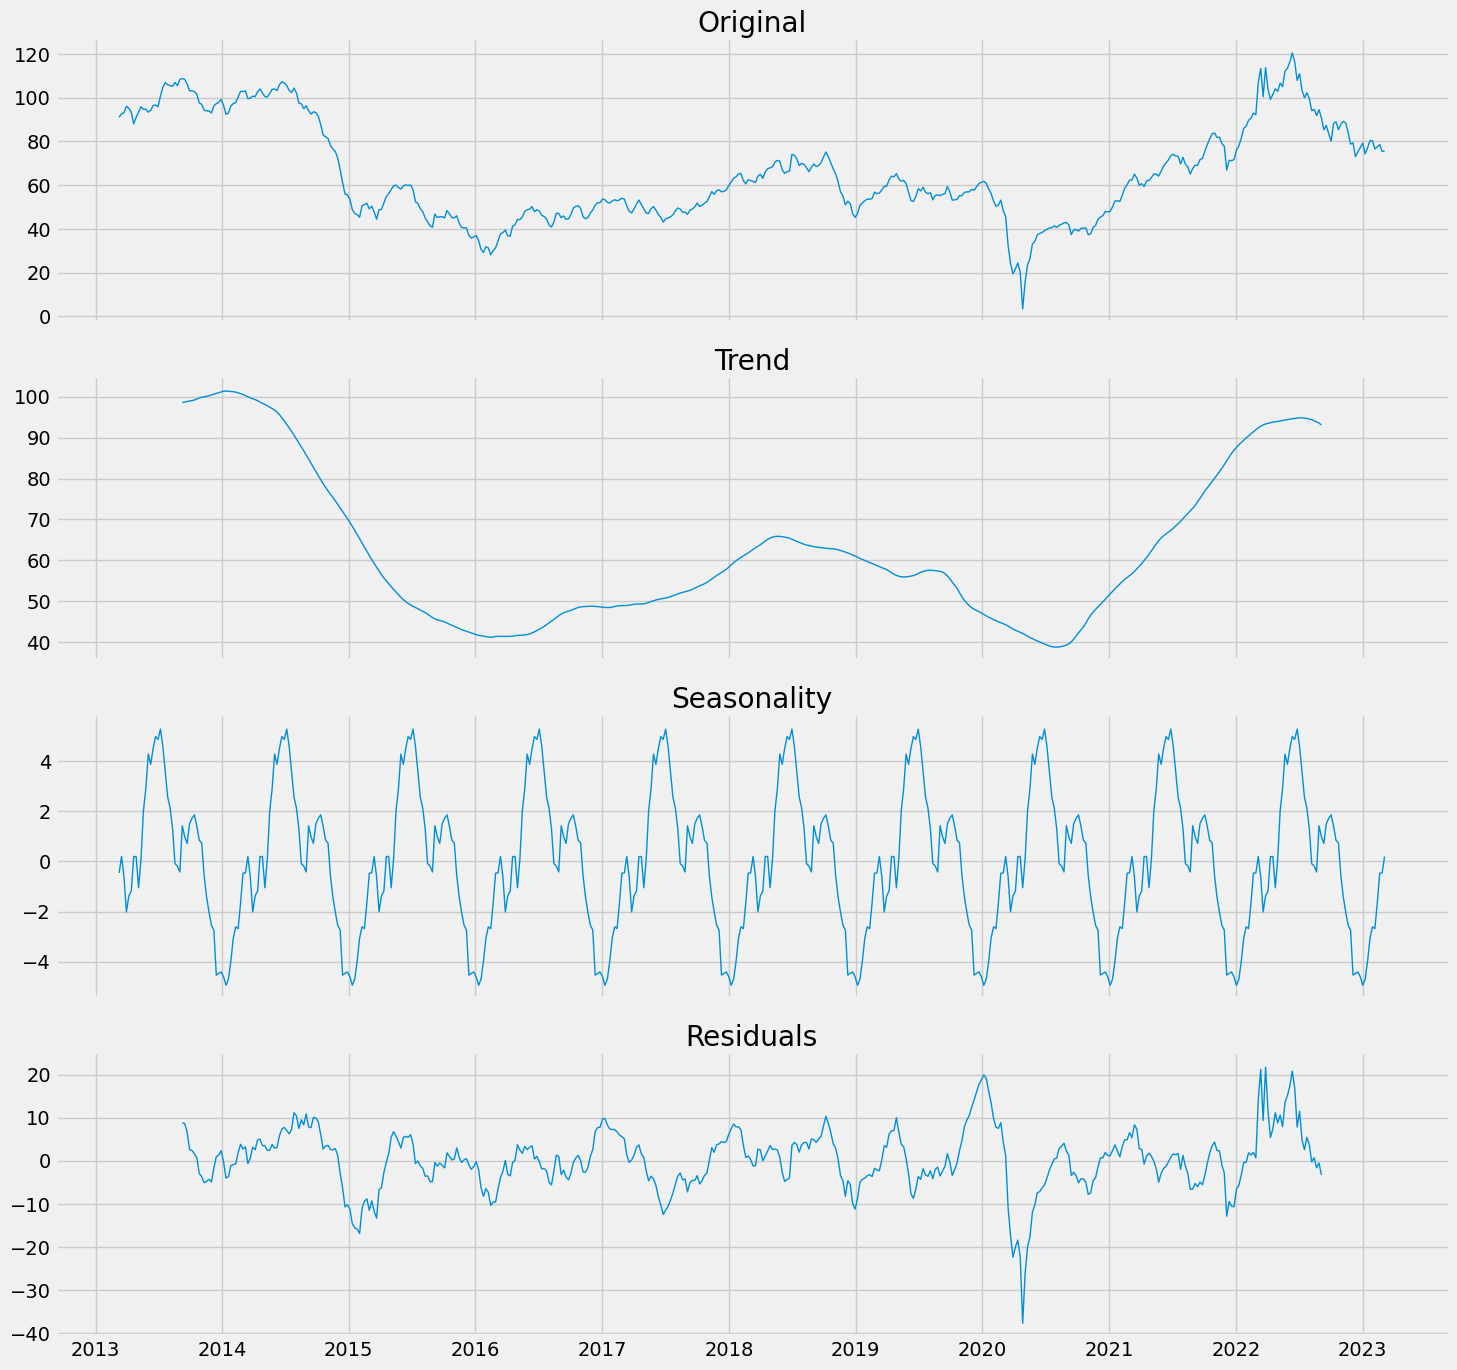

In [29]:
decomposition = seasonal_decompose(ts, period=52)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False, figsize=(16,16))
ax[0].plot(ts)
ax[0].set_title('Original')
ax[0].grid(True) 
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[1].grid(True)  
ax[2].plot(seasonal)
ax[2].set_title('Seasonality')
ax[2].grid(True)  
ax[3].plot(residual)
ax[3].set_title('Residuals')
ax[3].grid(True)


##### Modeling

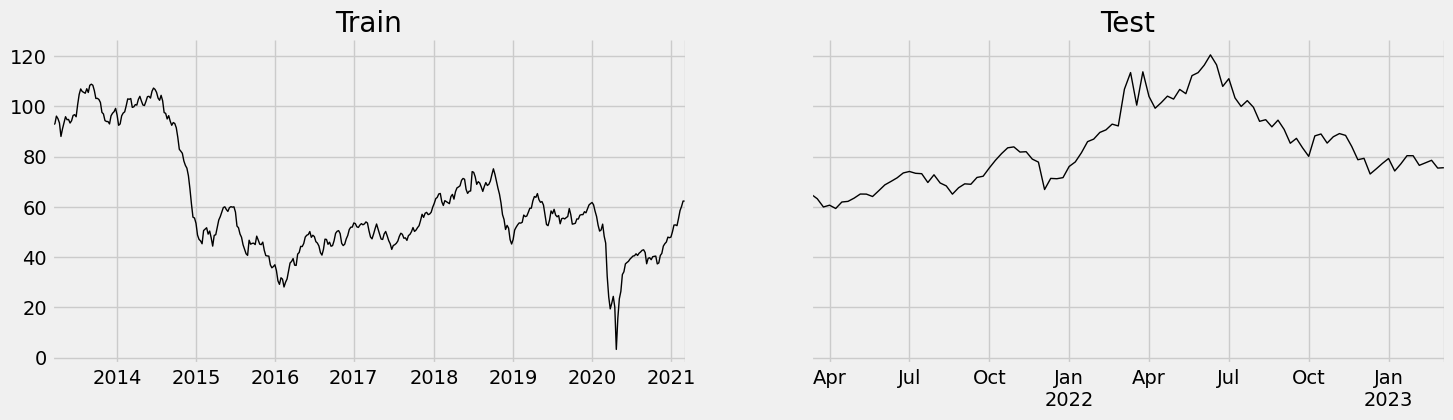

In [31]:
# Train test split
test_size=int(len(ts)*0.2)
train=ts[:-test_size]
test=ts[-test_size:]

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(16,4))
train.plot(ax=ax[0], grid=True, title="Train", color="black")
test.plot(ax=ax[1], grid=True, title="Test", color="black")
ax[0].set(xlabel=None)
ax[1].set(xlabel=None)
plt.show()

###### ARIMA

In [35]:
from pmdarima import auto_arima

best_model = auto_arima(train,                                   
                        seasonal=True, stationary=False, 
                        m=7, information_criterion='aic', 
                        max_order=20,                                     
                        max_p=10, max_d=3, max_q=10,                                     
                        max_P=10, max_D=3, max_Q=10,                                   
                        error_action='ignore')

print("best model --> (p, d, q):", best_model.order, " and  (P, D, Q, s):", best_model.seasonal_order)


best model --> (p, d, q): (0, 1, 1)  and  (P, D, Q, s): (0, 0, 0, 7)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28070D+00    |proj g|=  6.63006D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.343D-06   2.281D+00
  F =   2.2806675521448176     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<Axes: xlabel='DATE'>

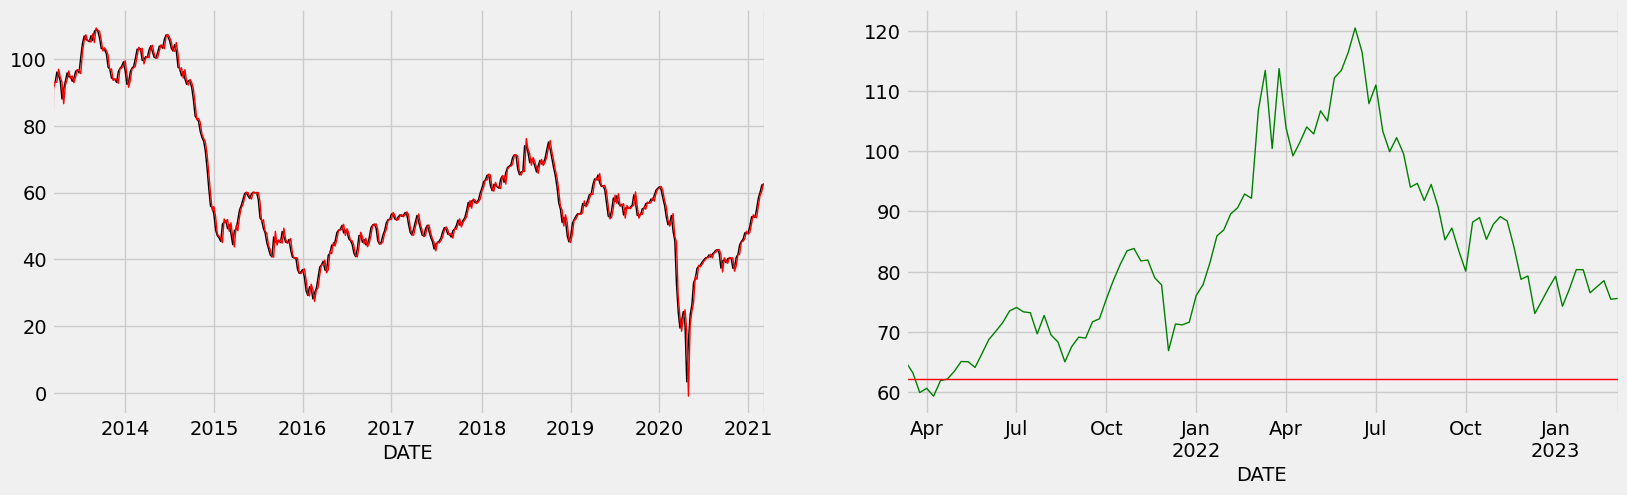

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax=SARIMAX(train, order=best_model.order, seasonal_order=best_model.seasonal_order).fit()

trainp=sarimax.fittedvalues
testp=sarimax.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

fig, ax = plt.subplots(1,2)
train.plot(ax=ax[0], color='black')
trainp.plot(ax=ax[0], color='red')

test.plot(ax=ax[1], color='green')
testp.plot(ax=ax[1], color='red')